Cell 1: Imports and Setup

This cell contains all necessary imports and sets up the plotting style.

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.seasonal import STL

warnings.filterwarnings("ignore")

# --- Plotting Style Setup ---
def setup_plot_style():
    """Sets a clean, professional style for all plots."""
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.rcParams['grid.alpha'] = 0.3
    plt.rcParams['grid.linestyle'] = ':'
    plt.rcParams['grid.linewidth'] = 0.8
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    plt.rcParams['axes.labelsize'] = 12
    plt.rcParams['axes.titlesize'] = 14
    plt.rcParams['xtick.labelsize'] = 10
    plt.rcParams['ytick.labelsize'] = 10
    plt.rcParams['figure.facecolor'] = 'white'
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['figure.figsize'] = (12, 6)

# Apply the style
setup_plot_style()

Cell 2: Helper Functions

This cell holds the utility functions for plotting and stationarity checking.

In [89]:
def check_stationarity(series, alpha=0.05):
    """
    Performs the Augmented Dickey-Fuller test to check for stationarity.
    Returns True if stationary, False otherwise.
    """
    result = adfuller(series.dropna())
    pval = result[1]
    print(f"    ADF Statistic: {result[0]:.4f}, p-value: {pval:.4f}")
    return pval <= alpha

def plot_with_ci(dates, series, label, color=None, ci_lower=None, ci_upper=None, linestyle='-', linewidth=2, alpha=0.2):
    """Helper function to plot a time series with an optional confidence interval."""
    plt.plot(dates, series, label=label, color=color, linestyle=linestyle, linewidth=linewidth)
    if ci_lower is not None and ci_upper is not None:
        plt.fill_between(dates, ci_lower, ci_upper, alpha=alpha, label=f"{label} CI", color=color)

Cell 3: Global Data Health Check

Before processing, we'll do a one-time check on the entire dataset to visualize the missing data problem. This provides context for why interpolation is necessary.

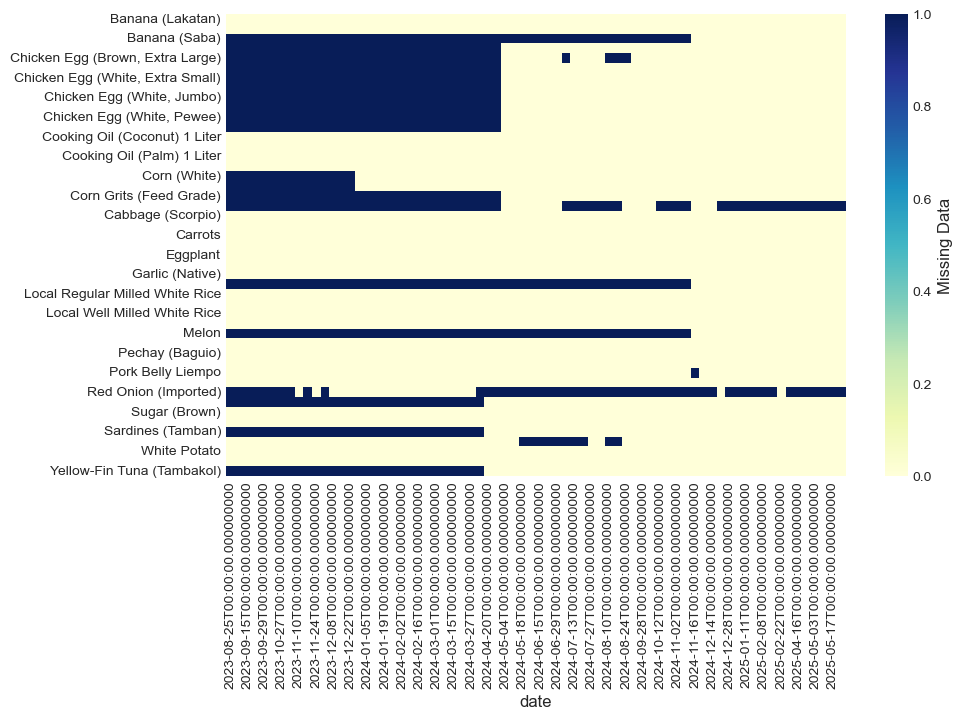

In [92]:
# --- List of all commodities to be processed ---
commodities = [
    "Banana (Lakatan)", "Banana (Latundan)", "Banana (Saba)",
    "Chicken Egg (Brown, Large)", "Chicken Egg (Brown, Extra Large)", "Chicken Egg (Brown, Medium)",
    "Chicken Egg (White, Extra Small)", "Chicken Egg (White, Extra Large)", "Chicken Egg (White, Jumbo)",
    "Chicken Egg (White, Large)", "Chicken Egg (White, Pewee)", "Chicken Egg (White, Small)",
    "Cooking Oil (Coconut) 1 Liter", "Cooking Oil (Coconut) 350 ml", "Cooking Oil (Palm) 1 Liter",
    "Cooking Oil (Palm) 350 ml", "Corn (White)", "Corn (Yellow)", "Corn Grits (Feed Grade)",
    "Corn Grits (White, Food Grade)", "Cabbage (Scorpio)", "Calamansi", "Carrots",
    "Imported Premium White Rice", "Eggplant", "Garlic (Imported)", "Garlic (Native)",
    "Lettuce (Iceberg)", "Local Regular Milled White Rice", "Local Premium White Rice",
    "Local Well Milled White Rice", "Mango (Carabao)", "Melon", "Papaya",
    "Pechay (Baguio)", "Pechay (Native)", "Pork Belly Liempo", "Pork Ham Kasim",
    "Red Onion (Imported)", "Salmon Head", "Sugar (Brown)", "Sugar (Refined)",
    "Sardines (Tamban)", "White Onion (Imported)", "White Potato",
    "Whole Chicken Fully Dressed", "Yellow-Fin Tuna (Tambakol)"
]

# --- Global Data Health Check ---
full_df = pd.read_csv('price_matrix.csv')
full_df['date'] = pd.to_datetime(full_df['date'])
full_df = full_df.set_index('date').sort_index()

plt.figure(figsize=(10,6))
sns.heatmap(full_df[commodities].isna().transpose(),
            cmap="YlGnBu",
            cbar_kws={'label': 'Missing Data'})
plt.savefig("visualizing_missing_data_with_heatmap_Seaborn_Python.png", dpi=100)

Cell 4: Data Preprocessing Pipeline

This cell defines all data processing steps in one function. It now includes the visualize flag to generate our new plots for a single commodity.

In [95]:
def preprocess_commodity_data(csv_file, commodity_name, visualize=False):
    """
    Loads, interpolates, resamples, and checks stationarity for a single commodity.
    Includes an option to visualize the entire process.
    """
    
    # --- 1. Load Data ---
    df_raw = pd.read_csv(csv_file)
    df_raw['date'] = pd.to_datetime(df_raw['date'])
    df_raw.set_index('date', inplace=True)
    df_raw.sort_index(inplace=True)
    s_raw = df_raw[[commodity_name]]
    
    print(f"Initial missing values: {s_raw.isna().sum().values[0]}")

    # --- 2. Interpolate ---
    s_filled = s_raw[commodity_name].interpolate(method='linear', limit=2)
    s_filled = s_filled.interpolate(method='cubic', limit_direction='both')
    s_filled = s_filled.ffill().bfill()
    print(f"Missing after interpolation: {s_filled.isna().sum()}")

    # --- 3. Resample to Weekly ---
    df_processed = s_filled.resample('W').mean().to_frame()
    df_processed = df_processed.ffill()
    n = len(df_processed)
    print(f"Data prepared: {n} weeks")
    
    # --- 4. Determine Stationarity ---
    stationary = check_stationarity(df_processed[commodity_name])
    d = 0 if stationary else 1
    m = min(52, max(4, n // 4)) # Seasonal period
    print(f"    Using seasonal period m={m}, differencing d={d}")

    # --- 5. (Optional) Visualize Processing Steps ---
    if visualize:
        print(f"\n--- Visualizing Processing for {commodity_name} ---")
        
        # Plot 1: Before vs. After Interpolation (on a raw daily slice)
        slice_start, slice_end = '2024-01-01', '2024-06-01'
        raw_slice = s_raw.loc[slice_start:slice_end, commodity_name]
        
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
        ax1.plot(raw_slice.index, raw_slice, 'o-', label='Raw Data (Daily)', color='gray', alpha=0.7)
        ax1.set_title(f'1. Raw Data for {commodity_name} (with Gaps)', fontsize=14)
        ax1.legend()
        ax1.grid(linestyle=':', alpha=0.5)
        
        processed_slice = df_processed.loc[slice_start:slice_end, commodity_name]
        ax2.plot(processed_slice.index, processed_slice, 'o-', label='Processed Data (Weekly, Interpolated)', color='#007ACC')
        ax2.set_title(f'2. Processed Data (Filled & Resampled to Weekly)', fontsize=14)
        ax2.legend()
        plt.suptitle(f'Interpolation & Resampling for {commodity_name}', fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'interpolation_{commodity_name}.png')
        plt.show()

        # Plot 2: STL Decomposition
        stl = STL(df_processed[commodity_name], seasonal=13, period=m)
        res = stl.fit()
        fig = res.plot()
        fig.set_size_inches(10, 8)
        fig.suptitle(f'STL Decomposition for {commodity_name}', fontsize=16, y=1.02, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f'stl_decomposition_{commodity_name}.png')
        plt.show()

        # Plot 3: Original vs. Differenced Series (if d=1)
        if d == 1:
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
            df_processed[commodity_name].plot(ax=ax1, title='Original Series (Non-Stationary)', color='blue')
            df_processed[commodity_name].rolling(window=m).mean().plot(ax=ax1, label=f'{m}-Week Rolling Mean', color='red', linestyle='--')
            ax1.legend()
            ax1.set_ylabel('Price')
            
            df_processed[commodity_name].diff().dropna().plot(ax=ax2, title='After 1st-Order Differencing (Stationary)', color='green')
            ax2.set_ylabel('Price Difference')
            
            plt.suptitle(f'Stationarity Transformation for {commodity_name} (d=1)', fontsize=16, fontweight='bold')
            plt.tight_layout()
            plt.savefig(f'stationarity_{commodity_name}.png')
            plt.show()
            
    return df_processed, d, m

Cell 5: Preprocessing in Action (Demonstration)

Here, we run the preprocessing function for one commodity with visualize=True. This single-run cell demonstrates the entire processing pipeline.

--- Running Demonstration of Preprocessing Pipeline ---
Initial missing values: 36
Missing after interpolation: 0
Data prepared: 92 weeks
    ADF Statistic: -1.3137, p-value: 0.6229
    Using seasonal period m=23, differencing d=1

--- Visualizing Processing for Chicken Egg (Brown, Extra Large) ---


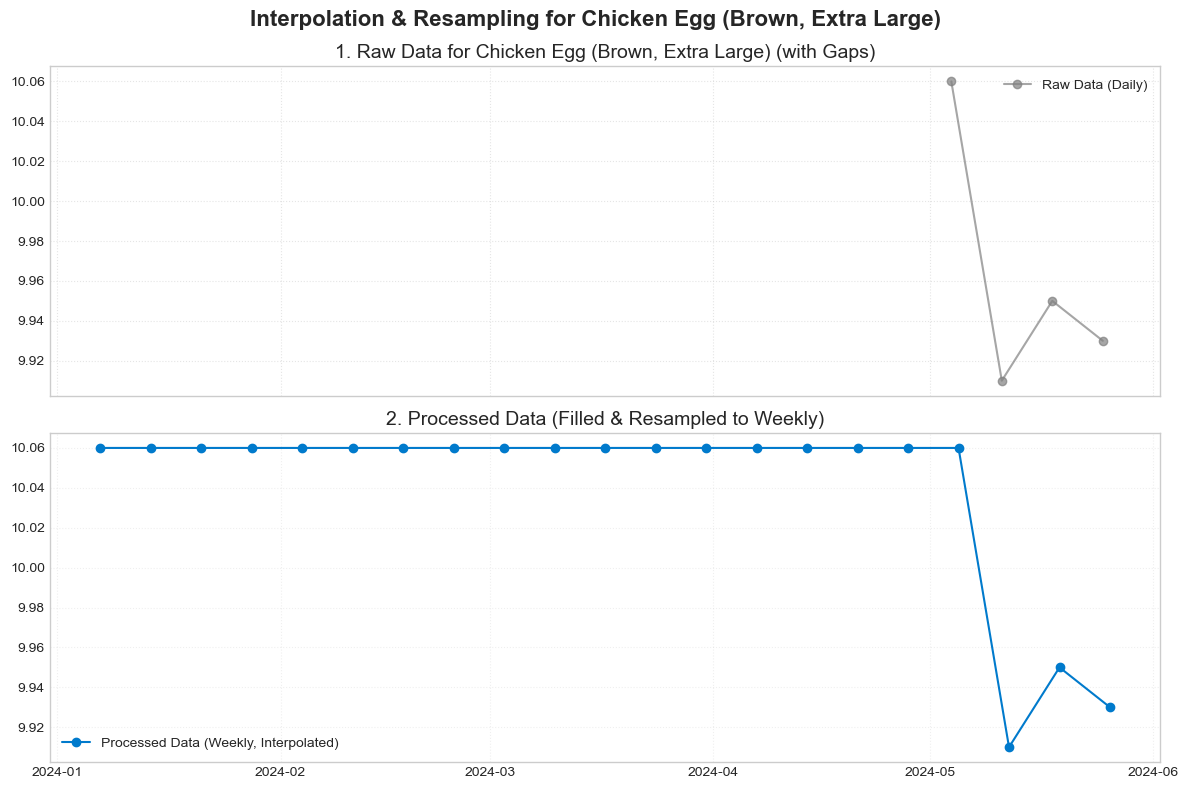

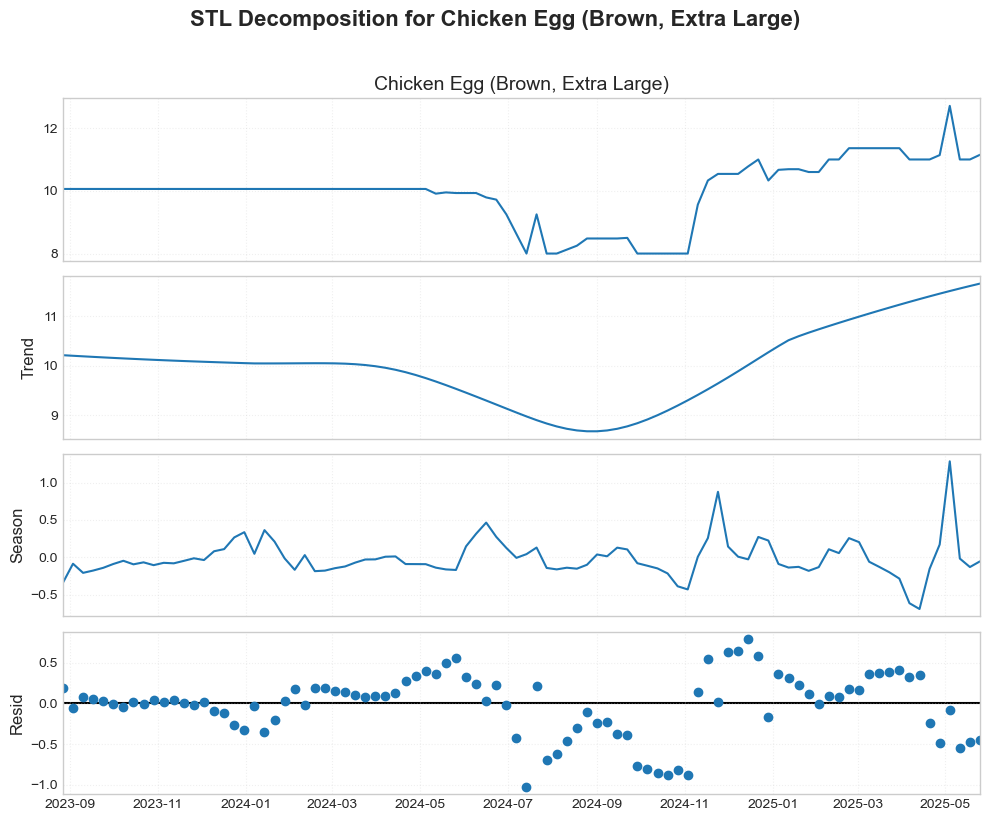

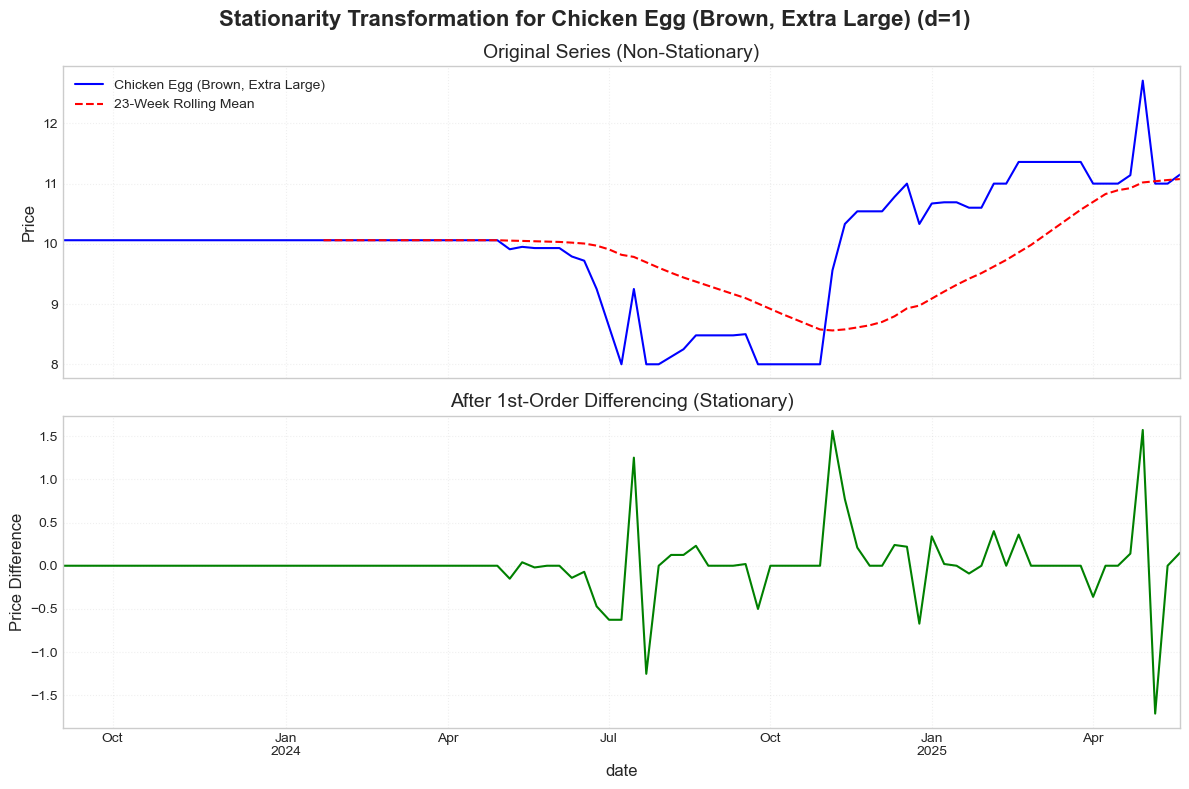

In [98]:
# --- Demonstrate the preprocessing pipeline ---
# We use 'Chicken Egg (Brown, Extra Large)' as it has significant missing data
print("--- Running Demonstration of Preprocessing Pipeline ---")
try:
    _ = preprocess_commodity_data(
        'price_matrix.csv', 
        commodity_name='Chicken Egg (Brown, Extra Large)', 
        visualize=True
    )
except Exception as e:
    print(f"Could not run demonstration. Error: {e}")

Cell 6: Model Creation, Optimization, and Forecasting

These functions now only handle modeling. They are separate from all data processing.

In [101]:
def train_evaluate_ensemble(df_processed, commodity_name, d, m, train_split=0.8):
    """
    Trains and evaluates the SARIMA-Holt Winters ensemble model.
    Returns metrics and the fully trained models.
    """
    price_col = commodity_name
    n = len(df_processed)
    train_size = int(train_split * n)
    train, test = df_processed[price_col].iloc[:train_size], df_processed[price_col].iloc[train_size:]
    print(f"    Train size: {len(train)}, Test size: {len(test)}")
    
    # --- 1. Tune and Fit SARIMA ---
    print("    Tuning SARIMA...")
    try:
        auto_model = auto_arima(
            train, seasonal=True, m=m, d=d, D=1, start_p=1, start_q=1,
            max_p=5, max_q=5, start_P=0, start_Q=0, max_P=2, max_Q=2,
            stepwise=True, trace=False, error_action='ignore',
            suppress_warnings=True, max_order=15
        )
        order, seasonal_order = auto_model.order, auto_model.seasonal_order
    except Exception as e:
        print(f"    Auto ARIMA failed: {e}. Using default orders.")
        order, seasonal_order = (1, d, 1), (0, 1, 1, m)
        
    print(f"    Selected SARIMA order: {order}, seasonal_order: {seasonal_order}")

    sarima_mod = SARIMAX(
        train, order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    
    sarima_pred = sarima_mod.get_forecast(steps=len(test)).predicted_mean

    # --- 2. Fit Holt-Winters ---
    try:
        hw_mod = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=m).fit()
        hw_pred = hw_mod.forecast(len(test))
    except Exception as e:
        print(f"    Holt-Winters failed: {e}. Using last value persistence.")
        hw_pred = pd.Series([train.iloc[-1]] * len(test), index=test.index)

    # --- 3. Create Ensemble Prediction ---
    preds = 0.7 * sarima_pred + 0.3 * hw_pred

    # --- 4. Evaluate Ensemble ---
    mae = mean_absolute_error(test, preds)
    rmse = np.sqrt(mean_squared_error(test, preds))
    mape = mean_absolute_percentage_error(test, preds) * 100
    print(f"    MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")
    
    metrics = {'MAE': mae, 'RMSE': rmse, 'MAPE': mape, 'SARIMA_Order': str(order), 'Seasonal_Order': str(seasonal_order)}

    # --- 5. Return Fully Trained Models (on all data) ---
    print("    Re-fitting models on full dataset...")
    full_sarima_mod = SARIMAX(
        df_processed[price_col], order=order, seasonal_order=seasonal_order,
        enforce_stationarity=False, enforce_invertibility=False
    ).fit(disp=False)
    
    try:
        full_hw_mod = ExponentialSmoothing(df_processed[price_col], trend='add', seasonal='add', seasonal_periods=m).fit()
    except:
        full_hw_mod = None # Will be handled in forecast function

    return metrics, full_sarima_mod, full_hw_mod

def forecast_future_ensemble(df_processed, sarima_mod, hw_mod, forecast_steps=2):
    """
    Generates future forecasts using the trained ensemble models.
    """
    # --- 1. SARIMA Future Forecast ---
    future_res = sarima_mod.get_forecast(steps=forecast_steps)
    future_pred = future_res.predicted_mean
    future_ci = future_res.conf_int() # We'll use SARIMA's CI as the primary one

    # --- 2. Holt-Winters Future Forecast ---
    if hw_mod is not None:
        hw_future = hw_mod.forecast(forecast_steps)
    else:
        # Handle failure case from training
        hw_future = pd.Series([df_processed[df_processed.columns[0]].iloc[-1]] * forecast_steps)

    # --- 3. Ensemble Future Forecast ---
    future_vals = 0.7 * future_pred + 0.3 * hw_future

    # --- 4. Format Output DataFrame ---
    last = df_processed.index[-1]
    future_idx = pd.date_range(start=last + pd.Timedelta(days=7), periods=forecast_steps, freq='W')
    future_df = pd.DataFrame({
        'forecast': future_vals.values,
        'lower_ci': future_ci.iloc[:, 0].values,
        'upper_ci': future_ci.iloc[:, 1].values
    }, index=future_idx)
    future_df.index.name = 'date'
    
    return future_df

Cell 7: Main Execution

This is the main script that runs the entire pipeline for all commodities. It also stores the evaluation metrics for every model, which is great for analysis.

In [104]:
# --- Main Execution: Run Pipeline for All Commodities ---

forecast_steps = 2
all_forecasts_list = []
all_metrics_list = []

# Get the future dates from the first commodity for consistency
try:
    print("--- Determining Future Dates ---")
    sample_df, d_sample, m_sample = preprocess_commodity_data(
        'price_matrix.csv', 
        commodities[0], 
        visualize=False
    )
    metrics_sample, sarima_sample, hw_sample = train_evaluate_ensemble(
        sample_df, commodities[0], d_sample, m_sample
    )
    sample_future_df = forecast_future_ensemble(
        sample_df, sarima_sample, hw_sample, forecast_steps
    )
    
    # Store first result
    future_dates = sample_future_df.index
    first_forecast = sample_future_df['forecast'].round(2).rename(commodities[0])
    all_forecasts_list.append(first_forecast)
    all_metrics_list.append({'Commodity': commodities[0], **metrics_sample})
    
    print(f"\nFuture dates established: {[d.strftime('%Y-%m-%d') for d in future_dates]}")

except Exception as e:
    print(f"Failed to process first commodity to get dates: {e}")
    # Create placeholder dates if we couldn't get actual forecast dates
    from datetime import datetime, timedelta
    start_date = datetime.now() + timedelta(days=7)
    future_dates = pd.date_range(start=start_date, periods=forecast_steps, freq='W')

# --- Process the rest of the commodities ---
# Skip the first one since we already did it
for commodity in commodities[1:]:
    print(f"\n--- Processing: {commodity} ---")
    try:
        # 1. Preprocess
        df_proc, d, m = preprocess_commodity_data(
            'price_matrix.csv', 
            commodity, 
            visualize=False
        )
        
        # 2. Train and Evaluate
        metrics, sarima_full, hw_full = train_evaluate_ensemble(
            df_proc, commodity, d, m
        )
        
        # 3. Forecast Future
        future_df = forecast_future_ensemble(
            df_proc, sarima_full, hw_full, forecast_steps
        )
        
        # 4. Store Results
        forecast_series = future_df['forecast'].round(2).rename(commodity)
        all_forecasts_list.append(forecast_series)
        all_metrics_list.append({'Commodity': commodity, **metrics})

    except Exception as e:
        print(f"    !!! FAILED for {commodity}: {e} !!!")
        # Add NaN values for this commodity
        nan_series = pd.Series([np.nan] * forecast_steps, index=future_dates, name=commodity)
        all_forecasts_list.append(nan_series)
        all_metrics_list.append({'Commodity': commodity, 'MAE': np.nan, 'RMSE': np.nan, 'MAPE': np.nan})

print("\n--- Pipeline Complete ---")

--- Determining Future Dates ---
Initial missing values: 0
Missing after interpolation: 0
Data prepared: 92 weeks
    ADF Statistic: -3.9817, p-value: 0.0015
    Using seasonal period m=23, differencing d=0
    Train size: 73, Test size: 19
    Tuning SARIMA...
    Selected SARIMA order: (1, 0, 0), seasonal_order: (1, 1, 0, 23)
    MAE: 4.19, RMSE: 4.31, MAPE: 3.99%
    Re-fitting models on full dataset...

Future dates established: ['2025-06-01', '2025-06-08']

--- Processing: Banana (Latundan) ---
Initial missing values: 0
Missing after interpolation: 0
Data prepared: 92 weeks
    ADF Statistic: -2.4372, p-value: 0.1315
    Using seasonal period m=23, differencing d=1
    Train size: 73, Test size: 19
    Tuning SARIMA...
    Selected SARIMA order: (0, 1, 0), seasonal_order: (0, 1, 0, 23)
    MAE: 2.36, RMSE: 2.49, MAPE: 3.19%
    Re-fitting models on full dataset...

--- Processing: Banana (Saba) ---
Initial missing values: 54
Missing after interpolation: 0
Data prepared: 92 weeks
 

Cell 8: Final Results and Analysis

This final cell formats and saves your results.

In [108]:
# --- Format and Save Final Forecasts ---
final_forecast_df = pd.concat(all_forecasts_list, axis=1)
final_forecast_df = final_forecast_df.reset_index().rename(columns={'index': 'date'})
final_forecast_df['date'] = final_forecast_df['date'].dt.strftime('%Y-%m-%d')

output_filename = 'Price_Forecasts.csv'
final_forecast_df.to_csv(output_filename, index=False)

print(f"\n Forecasts saved to {output_filename}")
print("\nSample of forecast results (Price_Forecasts.csv):")
print(final_forecast_df.head())


# --- Format and Save Model Performance Metrics ---
metrics_df = pd.DataFrame(all_metrics_list)
metrics_df = metrics_df.set_index('Commodity')

metrics_filename = 'Model_Performance_Metrics.csv'
metrics_df.to_csv(metrics_filename)

print(f"\n Metrics saved to {metrics_filename}")
print(f"\nSample of model performance (Model_Performance_Metrics.csv):")
print(metrics_df.head())


 Forecasts saved to Price_Forecasts.csv

Sample of forecast results (Price_Forecasts.csv):
         date  Banana (Lakatan)  Banana (Latundan)  Banana (Saba)  \
0  2025-06-01            106.29              74.62          50.83   
1  2025-06-08            106.26              74.72          50.12   

   Chicken Egg (Brown, Large)  Chicken Egg (Brown, Extra Large)  \
0                       10.07                             10.65   
1                       10.52                             11.58   

   Chicken Egg (Brown, Medium)  Chicken Egg (White, Extra Small)  \
0                        10.15                              6.61   
1                        10.14                              6.70   

   Chicken Egg (White, Extra Large)  Chicken Egg (White, Jumbo)  ...  \
0                              9.23                        9.86  ...   
1                              9.23                        9.93  ...   

   Pork Ham Kasim  Red Onion (Imported)  Salmon Head  Sugar (Brown)  \
0    